In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Any, List, Type


In [2]:
def gen_rand_data(n=10) -> np.ndarray:
    # fix the randomness state of the generator
    rand = np.random.RandomState(2)

    # gen the random data
    return rand.lognormal(mean=0, sigma=1, size=n)


rdata = gen_rand_data(10)
rdata


array([0.65918052, 0.94528687, 0.11810324, 5.15656576, 0.16638755,
       0.43095683, 1.65347878, 0.28785797, 0.347166  , 0.40292388])

(0.0, 6.0)

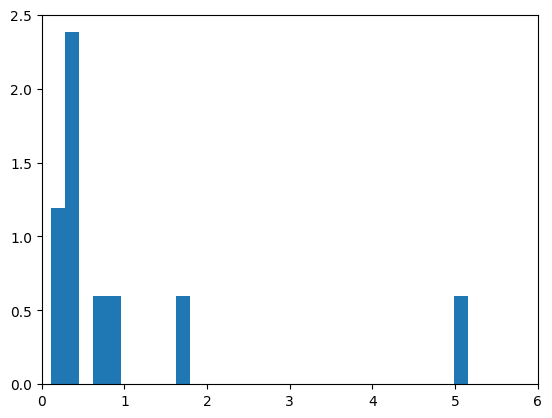

In [3]:
# data points
m = 30

hist = plt.hist(rdata, bins=m, density=True)
plt.xlim([0, 6])


### where the histogram normalisation has been selected so to make sure that the integral over the entire density is:

$$
\int\^{f}(x) dx = 1
$$


In [4]:
def check_sum(hist):
    density, bins, patches = hist
    widths = bins[1:] - bins[:-1]
    return np.sum((density * widths))


check_sum(hist)  # should return 1.0


0.9999999999999999

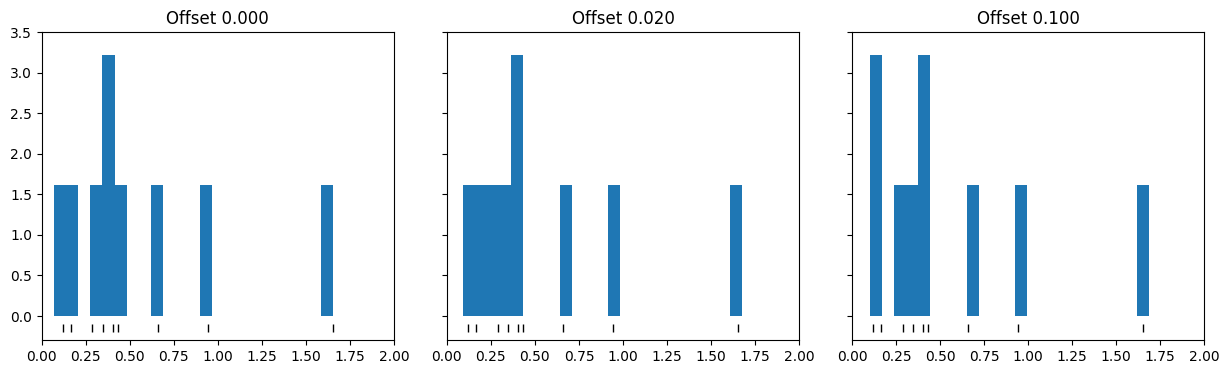

In [5]:
bins = np.linspace(0, 2, 30)

fig, ax = plt.subplots(
    1,
    3,
    figsize=(15, 4),
    sharex=True,
    sharey=True,
    subplot_kw={"xlim": (0, 2), "ylim": (-0.3, 3.5)},
)

fig.subplots_adjust(wspace=0.15)
for i, offset in enumerate([0.0, 0.02, 0.1]):
    ax[i].set_title(f"Offset {offset:.3f}")
    ax[i].hist(rdata, bins=bins + offset, density=True)
    ax[i].plot(rdata, np.full_like(rdata, -0.15), "|k", markeredgewidth=1)


ValueError: x and y must have same first dimension, but have shapes (10,) and (100,)

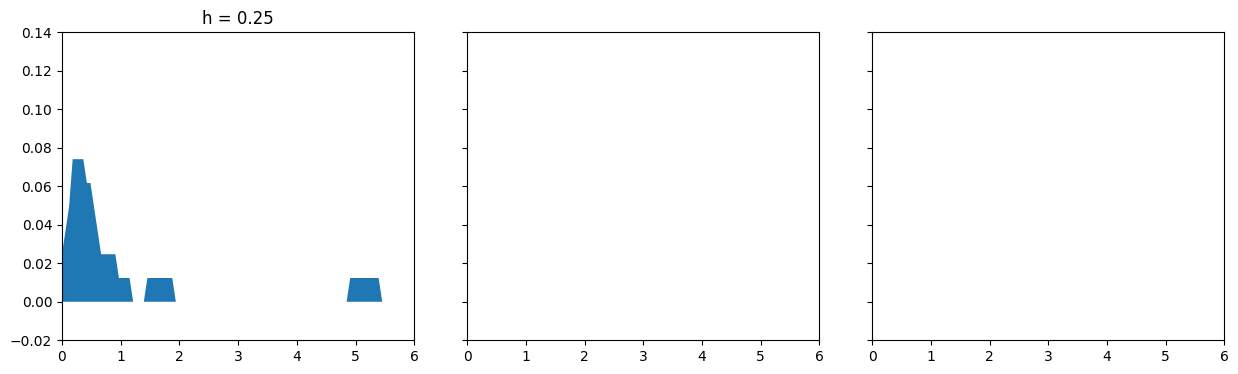

In [6]:
fig, ax = plt.subplots(
    1,
    3,
    figsize=(15, 4),
    sharex=True,
    sharey=True,
    subplot_kw={"xlim": (0, 6), "ylim": (-0.02, 0.14)},
)

fig.subplots_adjust(wspace=0.15)
for i, h in enumerate([0.25, 0.1, 0.05]):
    x_d = np.linspace(0, 6, 100)
    density = sum((abs(xi - x_d) < h) for xi in rdata)
    density = density / density.sum()
    ax[i].set_title(f"h = {h:.2f}")
    ax[i].fill_between(x_d, density)
    ax[i].plot(rdata, np.full_like(x_d, -0.01), "|k", markeredgewidth=1)


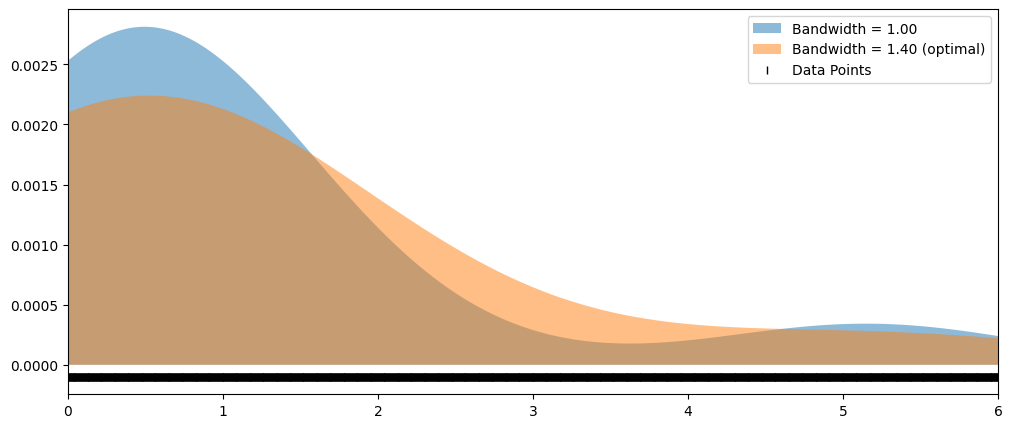

In [7]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV, LeaveOneOut

# fit kde model to rdata
bw = 1.0
kde = KernelDensity(bandwidth=bw, kernel="gaussian")
kde.fit(rdata[:, None])
# score sample returns the log of the probability density
x_d = np.linspace(0, 6, 1000)
logprob = kde.score_samples(x_d[:, None])
density = np.exp(logprob)
density = density / density.sum()

plt.figure(figsize=(12, 5))
plt.fill_between(x_d, density, alpha=0.5, label=f"Bandwidth = {bw:.2f}")
plt.plot(x_d, np.full_like(x_d, -0.0001), "|k", markeredgewidth=1)
plt.xlim([0, 6])

# find the optimal bandwith vals
bandwidths = 10 ** np.linspace(-1, 1, 1000)
grid = GridSearchCV(
    KernelDensity(kernel="gaussian"), {"bandwidth": bandwidths}, cv=LeaveOneOut()
).fit(rdata[:, None])

bw = grid.best_params_["bandwidth"]
# step 3: refit KDE model to rdata w/ optimal bandwidth
kde = KernelDensity(bandwidth=bw, kernel="gaussian").fit(rdata[:, None])
logprob = kde.score_samples(x_d[:, None])
density = np.exp(logprob)
# normalize density
density = density / density.sum()

plt.fill_between(x_d, density, alpha=0.5, label=f"Bandwidth = {bw:.2f} (optimal)")
plt.plot(x_d, np.full_like(x_d, -0.0001), "|k", markeredgewidth=1, label="Data Points")
plt.xlim([0, 6])
plt.legend(loc=1)


The LSCV is also referred to as the unbiased cross-validation since:

$$
E[LSCV(h)] = E \biggl \lbrace {\int{[f(y) - \^f_{h}(y)]^2dy}} \biggr \rbrace-\int{f(y)^2dy = MSE - \int{f(y)^2dy}}
$$